In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from datetime import datetime
from sklearn.svm import SVC
import operator
import googlefinance.client as gfc
from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

%matplotlib notebook

The goal of this notebook is to create time series regression models using some regression models as well as "Forest" models (both regression and deep learning versions). 

The features for this part of the research are going to be extracted using data freely available in Python via Quandl and pandas Yahoo finance support. 

- NASDAQ Composite
- Dow Jones Industrial Average
- Frankfurt DAX
- London FTSE-100
- Paris CAC 40
- Tokyo Nikkei-225
- Hong Kong Hang Seng
- Australia ASX-200

The features will be extracted from the major market indicators above will have the following format:

- Date : in days

- Open : price of the stock at the opening of the trading (in US dollars)
- High : highest price of the stock during the day (in US dollars)
- Low : lowest price of the stock during the trading day (in US dollars)
- Close : price of the stock at the closing of the trading (in US dollars)
- Volume : amount of stocks traded (in US dollars)
- Adj Close : price of the stock at the closing of the trading adjusted with dividends (in US dollars)

In [2]:
params = [
    {'q': "IXIC",
     'x': 'INDEXNASDAQ'
    },
    {'q': '.DJI',
      'x': 'INDEXDJX'  
    },
    {'q':'DAX',
     'x':'INDEXDB'   
    },
    {'q': 'UKX',
      'x':'INDEXFTSE'   
    },
    {'q': 'PX1',
      'x': 'INDEXEURO'   
    },
    {'q': 'NI225',
      'x': 'INDEXNIKKEI'  
    },
    {'q': 'HSI',
      'x': 'INDEXHANGSENG'  
    },
    {'q': 'XJO',
      'x':'INDEXASX'   
    },
    {'q': "SPY",
     'x': 'NYSEARCA'
    }
]
period = "2Y"
# get closing price data (return pandas dataframe)
df = gfc.get_closing_data(params, period)
df.head()

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO,SPY
2015-08-31,4776.508010,16528.03,10259.46,NaN,4652.95,18890.48,21670.58,5207.0,197.54
2015-09-01,4636.104961,16058.35,10015.57,6058.54,4541.16,18165.69,21185.43,5096.4,191.92
2015-09-02,4749.978882,16351.38,10048.05,6083.31,4554.92,18095.40,20934.94,5101.5,195.36
2015-09-03,4733.496516,16374.76,10317.84,6194.10,4653.79,18182.39,NaN,5027.8,195.65
2015-09-04,4683.918678,16102.38,10038.04,6042.92,4523.08,17792.16,20840.61,5040.6,192.56


In [3]:
# Log Days Returns: log of Adjusted Close Price of i-th day  compared to (i-1)-th day. 
log_returns = np.log(df) - np.log(df.shift(1))

In [4]:
# Percentage diff of adjusted cose price to 3 days ago
three_day_pct = df.pct_change(3)

In [5]:
three_day_pct.tail()

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO,SPY
2017-08-23,0.009954,0.006348,0.000749,0.008011,0.000242,-0.001837,NaN,-0.001723,0.007622
2017-08-24,0.009367,0.003670,0.009518,0.012048,0.005020,-0.002030,0.013402,0.003423,0.004487
2017-08-25,-0.005055,-0.003937,-0.005021,0.002671,-0.005365,0.003548,0.016294,-0.001078,-0.003585
2017-08-28,0.000734,-0.000169,-0.004175,NaN,-0.006967,0.000785,0.016846,-0.004758,0.000041
2017-08-29,0.004873,0.003763,-0.019289,-0.009400,-0.015883,0.000454,0.008954,-0.013315,0.003525


In [6]:
log_returns.head()

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO,SPY
2015-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-01,-0.029835,-0.028829,-0.024059,NaN,-0.024319,-0.039123,-0.022642,-0.021469,-0.028862
2015-09-02,0.024266,0.018083,0.003238,0.004080,0.003025,-0.003877,-0.011894,0.001000,0.017765
2015-09-03,-0.003476,0.001429,0.026496,0.018048,0.021474,0.004796,NaN,-0.014552,0.001483
2015-09-04,-0.010529,-0.016774,-0.027493,-0.024710,-0.028489,-0.021696,NaN,0.002543,-0.015920


In [7]:
df.corr(method='spearman')

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO,SPY
IXIC,1.000000,0.965407,0.943701,0.959437,0.825698,0.718970,0.930847,0.896474,0.975529
.DJI,0.965407,1.000000,0.883537,0.951757,0.739810,0.619388,0.858872,0.917627,0.995802
DAX,0.943701,0.883537,1.000000,0.905184,0.934998,0.848135,0.897150,0.854979,0.899766
UKX,0.959437,0.951757,0.905184,1.000000,0.793315,0.658468,0.914333,0.916781,0.956653
PX1,0.825698,0.739810,0.934998,0.793315,1.000000,0.917551,0.820802,0.727122,0.757904
NI225,0.718970,0.619388,0.848135,0.658468,0.917551,1.000000,0.705285,0.577607,0.636396
HSI,0.930847,0.858872,0.897150,0.914333,0.820802,0.705285,1.000000,0.820410,0.875966
XJO,0.896474,0.917627,0.854979,0.916781,0.727122,0.577607,0.820410,1.000000,0.924109
SPY,0.975529,0.995802,0.899766,0.956653,0.757904,0.636396,0.875966,0.924109,1.000000


In [8]:
df.corr(method='kendall')

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO,SPY
IXIC,1.000000,0.848776,0.792741,0.823976,0.638119,0.528917,0.790532,0.700161,0.881518
.DJI,0.848776,1.000000,0.702742,0.798645,0.544779,0.453685,0.686143,0.731535,0.946258
DAX,0.792741,0.702742,1.000000,0.741702,0.792409,0.644374,0.706601,0.655111,0.726204
UKX,0.823976,0.798645,0.741702,1.000000,0.617703,0.483080,0.741719,0.734267,0.814052
PX1,0.638119,0.544779,0.792409,0.617703,1.000000,0.743059,0.622587,0.524651,0.565345
NI225,0.528917,0.453685,0.644374,0.483080,0.743059,1.000000,0.515609,0.386813,0.464401
HSI,0.790532,0.686143,0.706601,0.741719,0.622587,0.515609,1.000000,0.605823,0.707438
XJO,0.700161,0.731535,0.655111,0.734267,0.524651,0.386813,0.605823,1.000000,0.745115
SPY,0.881518,0.946258,0.726204,0.814052,0.565345,0.464401,0.707438,0.745115,1.000000


<IPython.core.display.Javascript object>


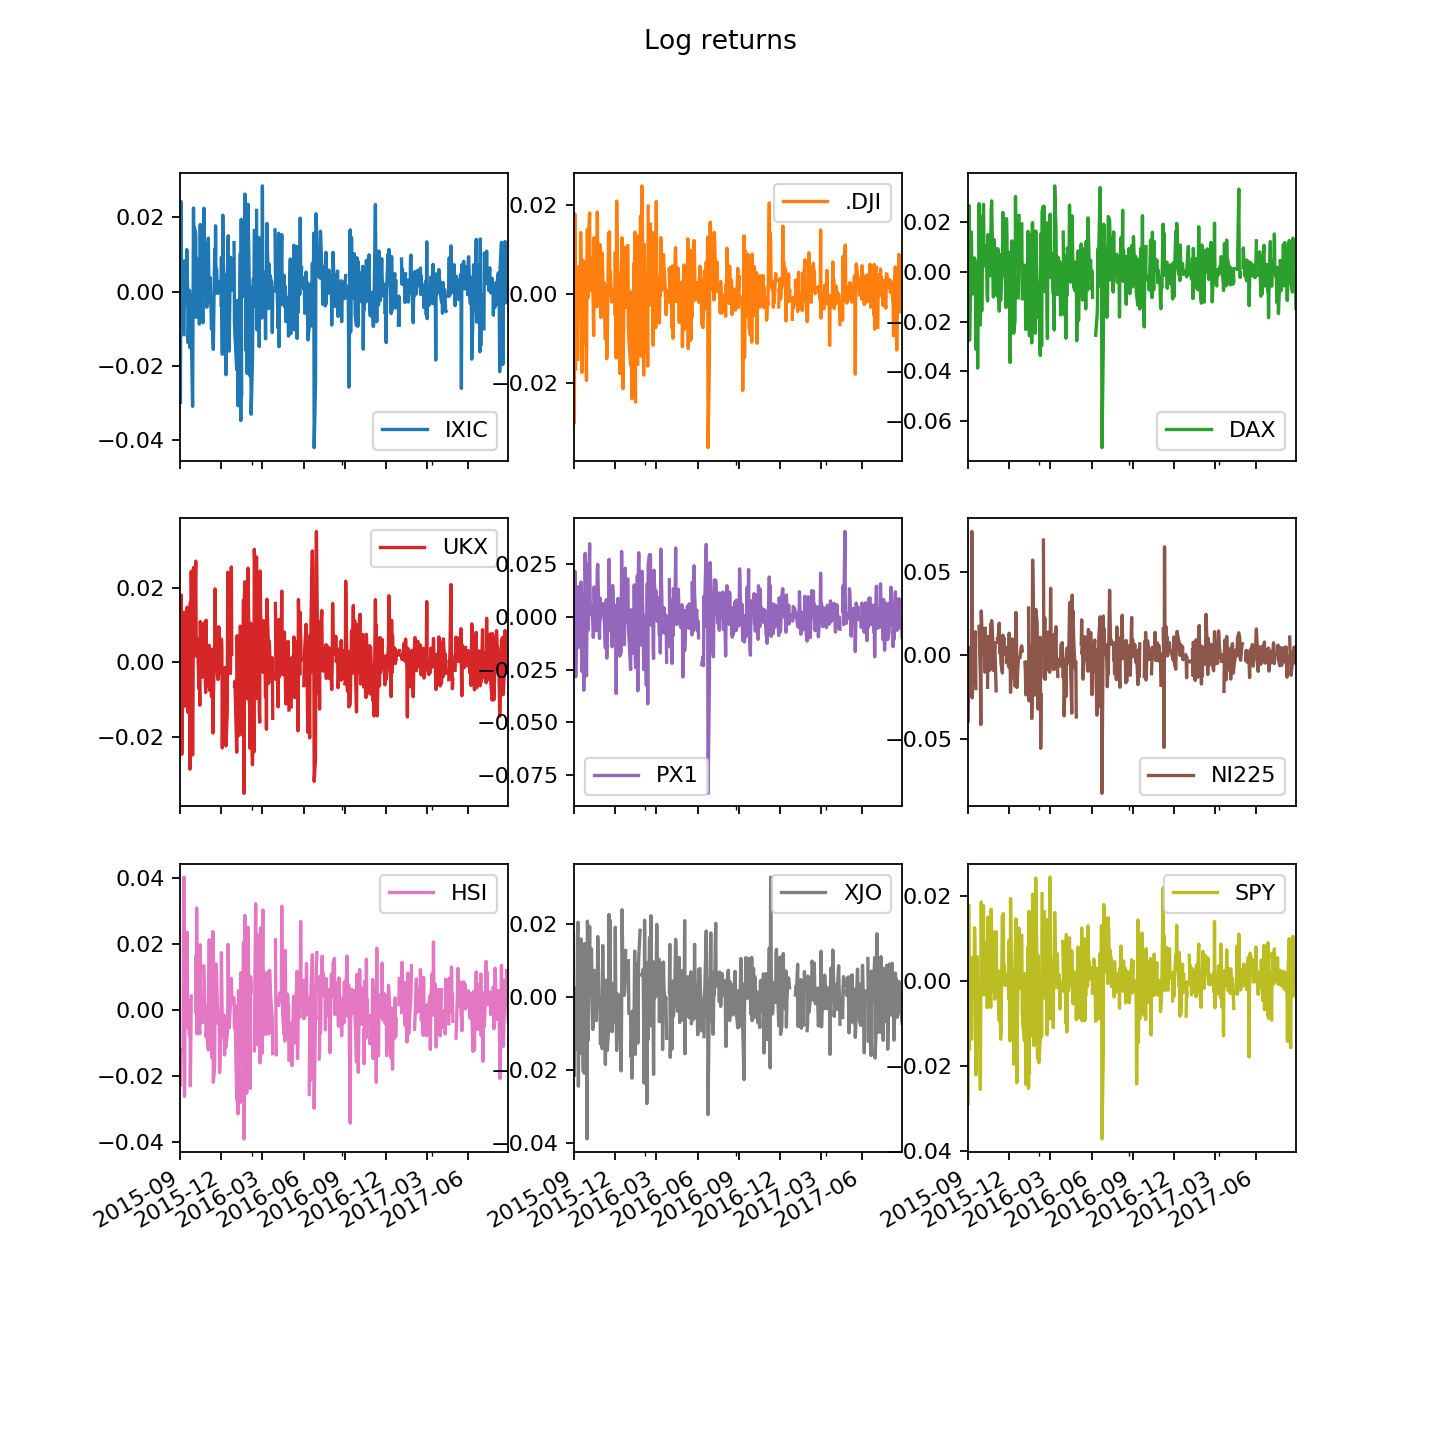

In [9]:
log_returns.plot(subplots=True, layout=(3, 3), 
                 figsize=(9, 9), sharex=True, title='Log returns');

In [10]:
log_returns = log_returns.dropna()
X = log_returns[log_returns.columns[0:-1]][0:-1]
y = log_returns[log_returns.columns[-1]][1:]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Ordinary Least Square

<IPython.core.display.Javascript object>


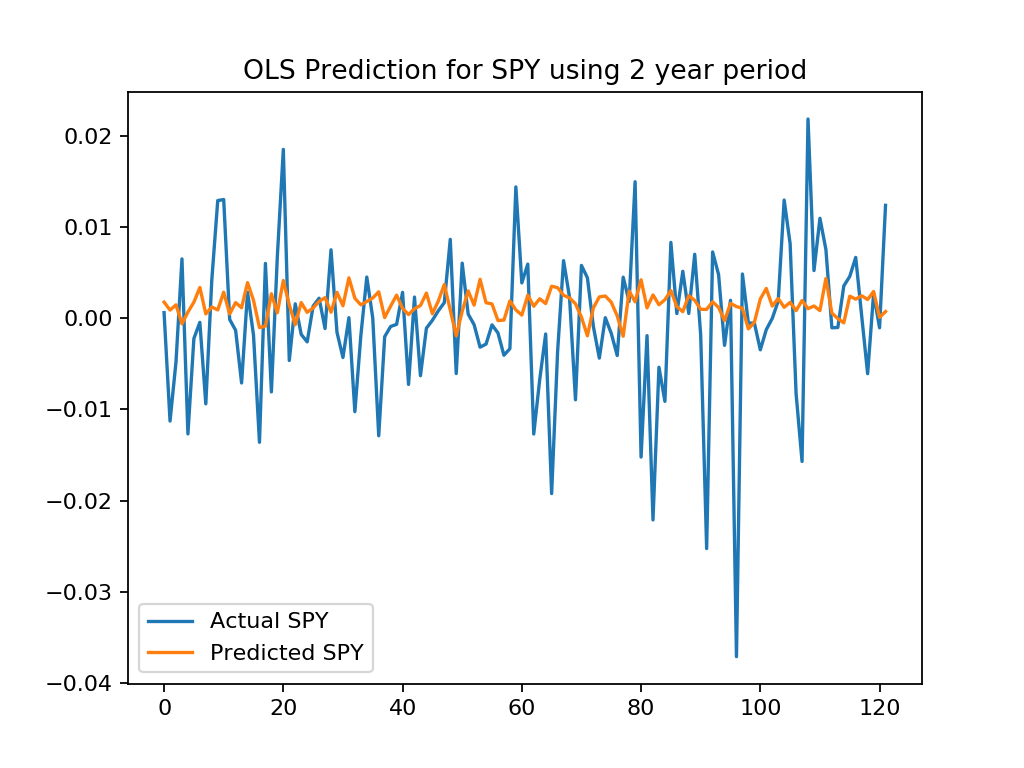

-0.094726968375202558

In [12]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_predicted = reg.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test.values.reshape(1, 122)[0], label='Actual SPY')
ax.plot(y_predicted, label='Predicted SPY')
ax.set_title('OLS Prediction for SPY using 2 year period')
plt.legend()


reg.score(X_test, y_test)

# RidgeCV Method

<IPython.core.display.Javascript object>


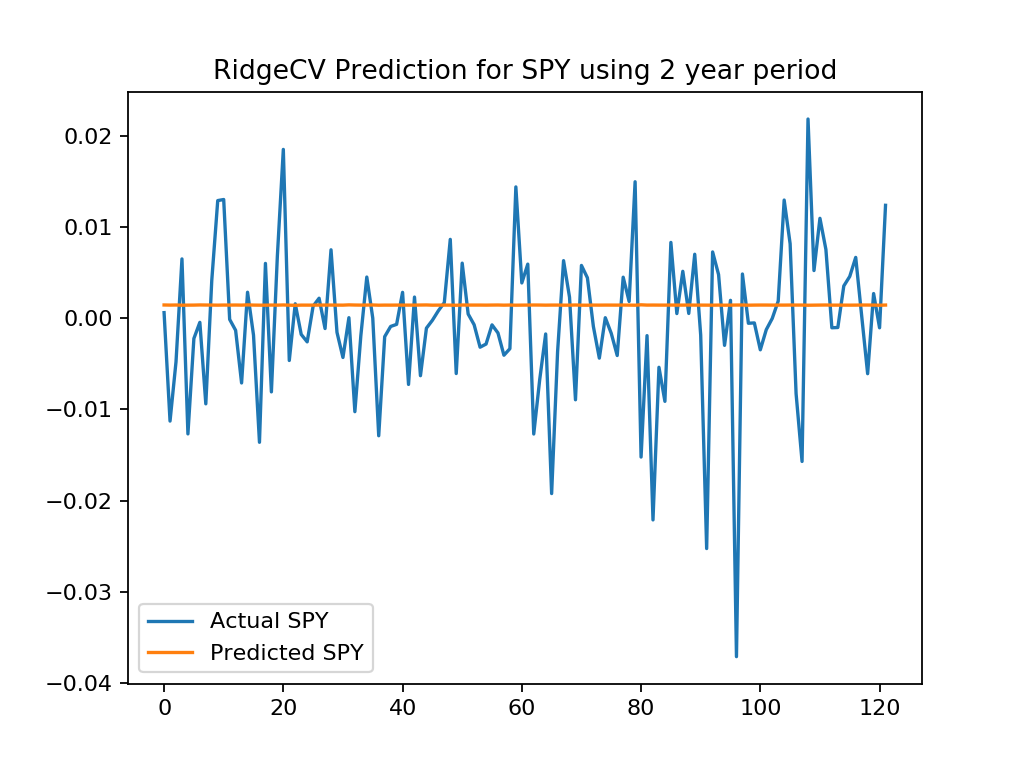

-0.057804320159221545

In [13]:
ridge = linear_model.RidgeCV()
ridge.fit(X_train, y_train)
y_ridge_predicted = ridge.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test.values.reshape(1, 122)[0], label='Actual SPY')
ax.plot(y_ridge_predicted, label='Predicted SPY')
ax.set_title('RidgeCV Prediction for SPY using 2 year period')
plt.legend()

ridge.score(X_test, y_test)

# Lasso 

<IPython.core.display.Javascript object>


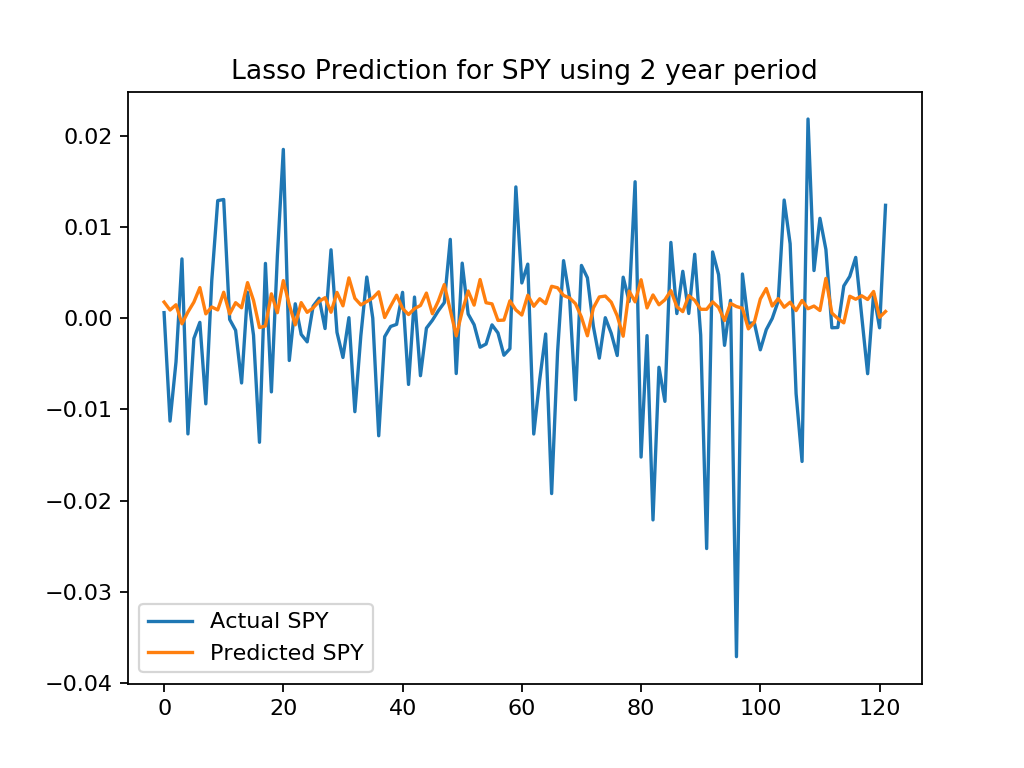

-0.094670674718013492

In [14]:
lasso = linear_model.Lasso(alpha = 1e-8)
lasso.fit(X_train, y_train)

y_predicted = lasso.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test.values.reshape(1, 122)[0], label='Actual SPY')
ax.plot(y_predicted, label='Predicted SPY')
ax.set_title('Lasso Prediction for SPY using 2 year period')
plt.legend()


lasso.score(X_test, y_test)

# Random Forest Regressor

<IPython.core.display.Javascript object>


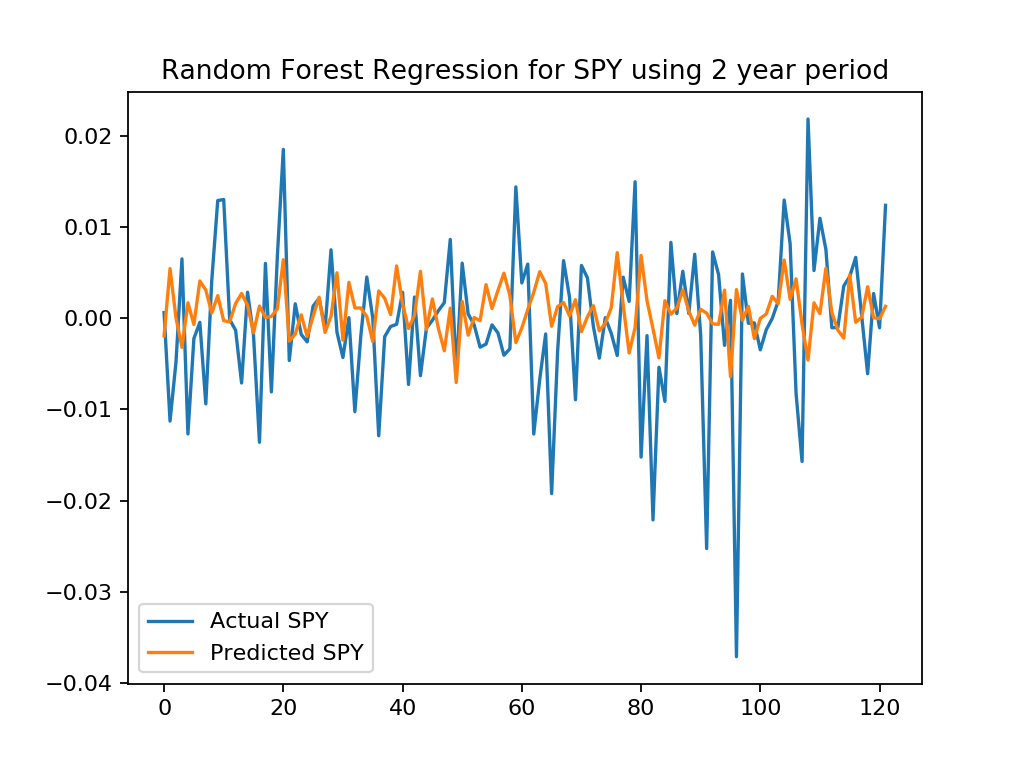

-0.210361776813069

In [15]:
regr = RandomForestRegressor(max_depth=20, random_state=0)
regr.fit(X_train, y_train)
regr_predicted = regr.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test.values.reshape(1, 122)[0], label='Actual SPY')
ax.plot(regr_predicted, label='Predicted SPY')
ax.set_title('Random Forest Regression for SPY using 2 year period')
plt.legend()

regr.score(X_test, y_test)